<a href="https://colab.research.google.com/github/MS-H2020/AOJ/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [モノクロ顔画像の感情分類 ](https://signate.jp/competitions/404)

## Google Colabでの設定

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Emotion_Classification_of_Monochrome_Face_Images/01_input.zip" .

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Emotion_Classification_of_Monochrome_Face_Images/')

In [3]:
TEMP_DIR = "./temp"
WEIGHT_DIR = "./weight"
INPUT_DIR:str = TEMP_DIR + "/01_input"
TRAIN_DIR:str = INPUT_DIR + "/train"
TEST_DIR:str = INPUT_DIR + "/test"
ANALYSIS_DIR:str = "/content/drive/MyDrive/Emotion_Classification_of_Monochrome_Face_Images/03_code-analysis"
MODEL_DIR:str = "/content/drive/MyDrive/Emotion_Classification_of_Monochrome_Face_Images//04_model"
SUBMISSION_DIR:str = '/content/drive/MyDrive/Emotion_Classification_of_Monochrome_Face_Images/05_submission'
CHECKPOINT_PATH:str = MODEL_DIR

In [4]:
import shutil
import os

if os.path.isdir(TEMP_DIR):
  shutil.rmtree(TEMP_DIR)

if os.path.isdir(WEIGHT_DIR):
  shutil.rmtree(WEIGHT_DIR)

import glob
import zipfile
shutil.unpack_archive('01_input.zip', TEMP_DIR)
os.mkdir(WEIGHT_DIR)

## メインコード

In [7]:
import os
import gc
import time

"""
from util import Logger, Util
logger = Logger()
"""

from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow
from tensorflow import keras
from tensorflow.keras import models, datasets, layers, applications, optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [8]:
############# Initial Setting #####################################
"""
INPUT_DIR:str = "../01_input"
TRAIN_DIR:str = INPUT_DIR + "/train"
TEST_DIR:str = INPUT_DIR + "/test"
ANALYSIS_DIR:str = "../03_code-analysis"
MODEL_DIR:str = "../04_model"
SUBMISSION_DIR:str = '../05_submission'
CHECKPOINT_PATH:str = MODEL_DIR
"""

IMG_WIDTH:int = 128
IMG_HEIGHT:int = 120
IMG_DEPTH:int = 1
BATCH_SIZE:int = 16 #Default:32

OneHold_or_Kfold : bool = True

#fold_num:int = 5 # Default:5
architecture:str = "mobile-net"
#architecture:str = "DenseNet"
#architecture:str = "VGG"
#architecture:str = "efficient-net"

#model_ver:int = 1
epochs:int = 50 # Defalut:50
lr:float = 0.001 # Default:0.001

#################################################################

In [9]:
df = pd.read_csv(INPUT_DIR+"/train_master.tsv", sep="\t")
df['expression'] = df['expression'].astype(str)
print(df)

                 id    userid      pose expression        eyes
0    train_0000.jpg     choon  straight      angry        open
1    train_0001.jpg      kk49  straight      angry        open
2    train_0002.jpg    phoebe     right        sad  sunglasses
3    train_0003.jpg  kawamura      left    neutral  sunglasses
4    train_0004.jpg      an2i      left      happy  sunglasses
..              ...       ...       ...        ...         ...
307  train_0307.jpg   karyadi  straight    neutral        open
308  train_0308.jpg      kk49  straight    neutral        open
309  train_0309.jpg   karyadi      left    neutral  sunglasses
310  train_0310.jpg      at33      left      happy        open
311  train_0311.jpg   danieln      left      angry        open

[312 rows x 5 columns]


## One-Hold法

In [10]:
#logger.info('start def fit_model_one_hold()')

from sklearn.model_selection import train_test_split
train_x, train_y = train_test_split(df, test_size=0.1, stratify=df['expression'], random_state=2)

metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
datagen = ImageDataGenerator(
  featurewise_center=False,
  samplewise_center=False,
  featurewise_std_normalization=True,
  samplewise_std_normalization=False,
  zca_whitening=False,
  zca_epsilon=1e-06,
  rotation_range=0.0,
  width_shift_range=0.00,
  height_shift_range=0.00,
  brightness_range=None,
  shear_range=0.0,
  zoom_range=0.0,
  channel_shift_range=0.0,
  fill_mode='nearest',
  cval=0.0,
  horizontal_flip=True,
  vertical_flip=False,
  rescale=1./255,
  preprocessing_function=None,
  data_format=None,
  #validation_split=0.1,
  interpolation_order=1,
  dtype=None
                            )

train_generator = datagen.flow_from_dataframe(
                            dataframe = train_x,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "expression",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            color_mode = 'grayscale',
                            class_mode='categorical',
                            shuffle=False
)

val_generator = datagen.flow_from_dataframe(
                            dataframe = train_y,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "expression",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            color_mode = 'grayscale',
                            class_mode='categorical',
                            shuffle=False
)

Found 280 validated image filenames belonging to 4 classes.
Found 32 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [13]:
t_x, t_y = next(train_generator)
base_model = applications.mobilenet.MobileNet(weights=None,include_top=False,input_shape=t_x.shape[1:])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


In [15]:
model = models.Sequential()
model.add(BatchNormalization(input_shape = t_x.shape[1:]))
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.trainable = False

#adam_low_rate = optimizers.legacy.Adam(learning_rate=lr)
adam_low_rate = optimizers.Adam(learning_rate=lr)

# モデルを構築
model.compile(optimizer=adam_low_rate,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#logger.info('end def build_model()')

In [16]:
# モデルの概要
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Bat  (None, 128, 120, 1)       4         
 chNormalization)                                                
                                                                 
 mobilenet_1.00_128 (Functi  (None, 4, 3, 1024)        3228288   
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 4, 3, 1024)        4096      
 chNormalization)                                                
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)             

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/50
17/17 [==============================] - 6s 224ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 2/50
17/17 [==============================] - 3s 174ms/step - loss: 1.3863 - accuracy: 0.2574 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/50
17/17 [==============================] - 4s 237ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/50
17/17 [==============================] - 3s 169ms/step - loss: 1.3863 - accuracy: 0.2574 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/50
17/17 [==============================] - 3s 165ms/step - loss: 1.3863 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/50
17/17 [==============================] - 3s 189ms/step - loss: 1.3863 - accuracy: 0.2538 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/50
17/17 [==============================] - 3s 201ms/step - loss: 1.3863 - accuracy: 0.2462 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Found 312 validated image filenames.


InvalidArgumentError: Graph execution error:

Detected at node sequential_1/batch_normalization_1/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-17-759ad42a1eb7>", line 60, in <cell line: 60>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py", line 979, in _fused_batch_norm_inference

scale must have the same number of elements as the channels of x, got 1 and 3
	 [[{{node sequential_1/batch_normalization_1/FusedBatchNormV3}}]] [Op:__inference_predict_function_8150]

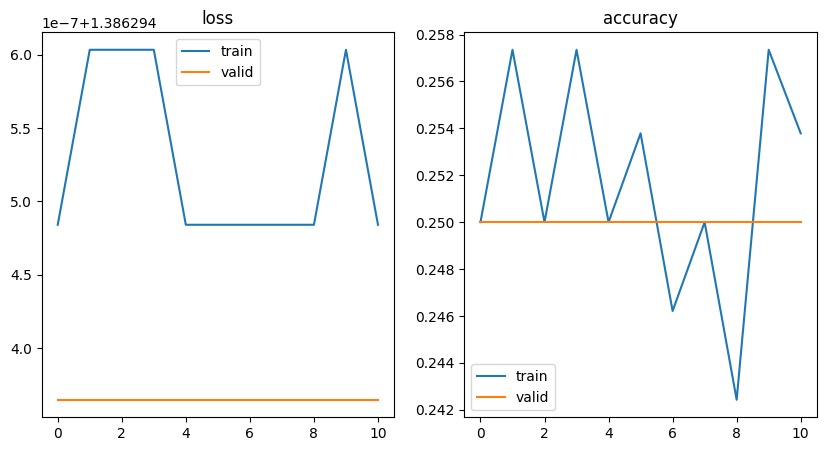

In [17]:
#logger.info(f'start traing')
# Early stoppingを適用してフィッティング
history = model.fit(train_generator,
                    validation_data = val_generator,
                    steps_per_epoch = train_generator.samples // BATCH_SIZE,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    verbose=True,
                    #callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1),
                    #           tensorflowkeras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)],
                    callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)],
                    epochs = epochs,
                    workers = 1
)

#logger.info(f'end traing')

# 評価する。
test_loss, test_acc = model.evaluate(val_generator)
#logger.result(f"test loss: {test_loss:.2f}, test accuracy: {test_acc:.2%}")

model_path = os.path.join(MODEL_DIR+'/cnn_'+architecture+'_OneHold.h5')
model.save(model_path)

plt.figure(figsize=(10, 5))  # グラフを表示するスペースを用意

for i in range(len(metrics)):
  metric = metrics[i]

  plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分ける
  plt.title(metric)

  plt_train = history.history[metric]
  plt_valid  = history.history['val_' + metric]

  plt.plot(plt_train, label='train')
  plt.plot(plt_valid, label='valid')
  plt.legend()

analysis_path = os.path.join(ANALYSIS_DIR+"/metrics_one_hold.png")
plt.savefig(analysis_path)


#logger.info('end def fit_model_one_hold')

import shutil
import glob


#os.makedirs(TEST_DIR+'/dummy/', exist_ok=True)
#for image_path in glob.glob(TEST_DIR + '/*.jpeg'):
#    shutil.move(image_path, TEST_DIR + '/dummy')

#logger.info('start predict by one_hold')

ans = pd.read_csv(INPUT_DIR+"/sample_submit.csv",  header=None)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(ans, TEST_DIR, x_col=0, target_size=(IMG_WIDTH,IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE, class_mode=None, shuffle=False)

prediction = model.predict(test_generator)
prediction = np.argmax(prediction,axis=1)

ans[1] = prediction

ans.to_csv(path_or_buf = SUBMISSION_DIR+"/submission_.csv", index=False, header=None)
#logger.info('start predict by one_hold')

## 混合行列

In [18]:
#logger.info('start def fit_model_one_hold()')

metrics = ['loss', 'accuracy']  # 使用する評価関数を指定
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
                            dataframe = train_x,
                            directory = TRAIN_DIR,
                            x_col = "id",
                            y_col = "target",
                            target_size=(IMG_WIDTH,IMG_HEIGHT),
                            batch_size=BATCH_SIZE,
                            class_mode='binary',
                            shuffle=False
)

KeyError: 'target'

In [ ]:
from tensorflow.keras.models import Model, load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/04_model/cnn_mobile-net_OneHold.h5')

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = model.predict(train_generator, train_generator.samples // BATCH_SIZE)
y_pred = np.where(Y_pred < 0.5, 0, 1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))
print('Classification Report')
print(classification_report(train_generator.classes, y_pred, target_names=None))

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

swarm_plot = sns.heatmap(confusion_matrix(train_generator.classes, y_pred), annot=True)
plt.xlabel("pred")
plt.ylabel('true')

fig = swarm_plot.get_figure()
fig.savefig(ANALYSIS_DIR+'Confusion_Matrix.png')